In [ ]:
##### All testing with best trained model #####


import gymnasium
import flappy_bird_gymnasium
import numpy as np
import pygame
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque,defaultdict
from enum import IntEnum
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv
from flappy_bird_gymnasium.envs.flappy_bird_env import Actions
from flappy_bird_gymnasium.envs.constants import (
    PLAYER_FLAP_ACC,
    PLAYER_ACC_Y,
    PLAYER_MAX_VEL_Y,
    PLAYER_HEIGHT,
    PLAYER_VEL_ROT,
    PLAYER_WIDTH,
    PIPE_WIDTH,
    PIPE_VEL_X,
)
import itertools
import cv2
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os


In [ ]:
##################################
#####      SARSA_LAMBDA      #####
#####         + None         #####
##################################

class QNetwork(nn.Module):
    def __init__(self, state_dim=180):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.network(x)

class TDLambdaCtrlFA:
    def __init__(self, env, current_hyperparams):
                
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.env = env
        self.learning_rate = current_hyperparams['learning_rate']
        self.gamma = current_hyperparams['gamma']
        self.lambda_ = current_hyperparams['lambda_']
        self.epsilon = current_hyperparams['epsilon_start']
        self.epsilon_end = current_hyperparams['epsilon_end']
        self.epsilon_decay = current_hyperparams['epsilon_decay']
        self.episodes= current_hyperparams['episodes']
        
        self.q_network = QNetwork().to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.traces = {}
        
    def select_action(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            return np.random.randint(2)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()
    
    def update_traces(self, state, action):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state_tensor)
        
        if not self.traces:
            for name, param in self.q_network.named_parameters():
                self.traces[name] = torch.zeros_like(param,device=self.device)
        
        q_values[0][action].backward()
        
        for name, param in self.q_network.named_parameters():
            self.traces[name] = self.gamma * self.lambda_ * self.traces[name] + param.grad
            param.grad.zero_()
    
    def train(self):
        res=[]
        print(f"Training with hyperparameters: lr={current_hyperparams['learning_rate']}, deps={current_hyperparams['epsilon_decay']}, lambda={current_hyperparams['lambda_']}")
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            self.traces = {}
            action = self.select_action(state)
            total_reward = 0
            
            while True:
                next_state, reward, done, truncated, _ = self.env.step(action)
                total_reward += reward
                next_action = self.select_action(next_state)
                
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
                
                current_q = self.q_network(state_tensor)[0][action]
                next_q = self.q_network(next_state_tensor)[0][next_action]
                
                td_error = reward + (1-done)*self.gamma*next_q.detach() - current_q
                
                self.update_traces(state, action)
                
                for name, param in self.q_network.named_parameters():
                    param.data += td_error.item() * self.traces[name]
                
                if done or truncated:
                    break
                
                state = next_state
                action = next_action
            
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            
            if episode % 100 == 0:
                avg_reward = np.mean(res[-100:])
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")
            res.append(total_reward)
            
        return res
    
    def save_model(self, path):
        torch.save(self.q_network.state_dict(), path)
        
    def load_model(self, path):
        self.q_network.load_state_dict(torch.load(path))
                
    def test(self, render="human", num_episodes=100):
        # Load best model at start of test
        if os.path.exists('best_model.pth'):
            self.load_model('best_model.pth')
            print("Loaded best model for testing")
            
        total_rewards = []
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode
        
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.select_action(state, training=False)
                state, reward, done, truncated, _ = test_env.step(action)
                total_reward += reward
                
                if truncated:
                    break
                
            print(f"Test Episode {episode}, Total Reward: {total_reward}")
                
            total_rewards.append(total_reward)
            
        avg_reward = np.mean(total_rewards)
        print(f"\nTesting Done! Average Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        
        return total_rewards
    
# Usage
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array",use_lidar=True)

exp_res = {}
test_res = {}

hyper = {
    "learning_rate": [0.001, 0.005],
    "gamma": 0.99,
    "lambda_":np.linspace(0.7, 0.98, 8).tolist(),
    "epsilon_start": 1.0,
    "epsilon_decay": [0.990, 0.995, 0.999],
    "epsilon_end": 0.01,
    "episodes": 50000
}

param_combinations = itertools.product(
    hyper["learning_rate"], 
    hyper["epsilon_decay"],
    hyper["lambda_"]
)


for lr, epsilon_decay,lmbda in param_combinations:
    current_hyperparams = {
        "learning_rate": lr,
        "gamma": hyper["gamma"],
        "lambda_": lmbda,
        "epsilon_start": hyper["epsilon_start"],
        "epsilon_decay": epsilon_decay,
        "epsilon_end": hyper["epsilon_end"],
        "episodes": hyper["episodes"]
    }

    agent = TDLambdaCtrlFA(env, current_hyperparams)

    exp_res[f"lr={lr}_decay={epsilon_decay}_lambda={lmbda}"] = agent.train()
    test_res[f"lr={lr}_decay={epsilon_decay}_lambda={lmbda}"] = agent.test(num_episodes=10)

Using device: cuda
Training with hyperparameters: lr=0.001, deps=0.99, lambda=0.7
Episode 0, Reward: -7.50, Avg: nan, Epsilon: 0.990
Episode 100, Reward: -0.90, Avg: -4.24, Epsilon: 0.362
Episode 200, Reward: -0.90, Avg: -0.57, Epsilon: 0.133
Episode 300, Reward: 0.60, Avg: 0.05, Epsilon: 0.049
Episode 400, Reward: -0.90, Avg: 0.51, Epsilon: 0.018


C:\Users\user\AppData\Local\Temp\ipykernel_25380\1770733433.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_network.load_state_dict(torch.load(path))


Loaded best model for testing
Test Episode 0, Total Reward: -9.299999999999999
Test Episode 1, Total Reward: -9.299999999999999
Test Episode 2, Total Reward: -9.299999999999999
Test Episode 3, Total Reward: -9.299999999999999
Test Episode 4, Total Reward: -9.299999999999999
Test Episode 5, Total Reward: -9.299999999999999
Test Episode 6, Total Reward: -9.299999999999999
Test Episode 7, Total Reward: -9.299999999999999
Test Episode 8, Total Reward: -9.299999999999999
Test Episode 9, Total Reward: -9.299999999999999

Testing Done! Average Reward over 10 Test Episodes: -9.299999999999999
Using device: cuda
Training with hyperparameters: lr=0.001, deps=0.99, lambda=0.74
Episode 0, Reward: -7.50, Avg: nan, Epsilon: 0.990
Episode 100, Reward: -0.90, Avg: -4.69, Epsilon: 0.362


KeyboardInterrupt: 

In [ ]:
##################################
#####      SARSA_LAMBDA      #####
#####  + Eligibility Traces  #####
##################################

class QNetwork(nn.Module):
    def __init__(self, state_dim=180):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.network(x)

class SarsaLambda:
    def __init__(self, env, current_hyperparams):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.env = env
        self.learning_rate = current_hyperparams['learning_rate']
        self.gamma = current_hyperparams['gamma']
        self.lambda_ = current_hyperparams['lambda_']
        self.epsilon = current_hyperparams['epsilon_start']
        self.epsilon_end = current_hyperparams['epsilon_end']
        self.epsilon_decay = current_hyperparams['epsilon_decay']
        self.episodes = current_hyperparams['episodes']
        
        self.q_net = QNetwork().to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.traces = {}
        self.best_reward = float('-inf')

    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(2)
            
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state)
            return q_values.argmax().item()

    def reset_traces(self):
        self.traces = {}
        for name, param in self.q_net.named_parameters():
            self.traces[name] = torch.zeros_like(param, device=self.device)

    def update(self, state, action, reward, next_state, next_action, done):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
        
        current_q = self.q_net(state)[0][action]
        next_q = self.q_net(next_state)[0][next_action]
        
        td_error = reward + (1 - done) * self.gamma * next_q.detach() - current_q
        
        self.optimizer.zero_grad()
        current_q.backward()
        
        for name, param in self.q_net.named_parameters():
            self.traces[name] = self.gamma * self.lambda_ * self.traces[name] + param.grad
            param.data += td_error.item() * self.traces[name]

    def train(self):
        print(f"Training with hyperparameters: lr={current_hyperparams['learning_rate']}, deps={current_hyperparams['epsilon_decay']}, lambda={current_hyperparams['lambda_']}")
    
        rewards_history = []
        
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            self.reset_traces()
            action = self.select_action(state)
            total_reward = 0
            
            while True:
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_action = self.select_action(next_state)
                
                self.update(state, action, reward, next_state, next_action, done)
                total_reward += reward
                
                if done or truncated:
                    break
                    
                state = next_state
                action = next_action
            
            rewards_history.append(total_reward)
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model('best_model.pth')
            
            if episode % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")
        
        return rewards_history
    
    def save_model(self, path):
        torch.save(self.q_net.state_dict(), path)
        
    def load_model(self, path):
        self.q_net.load_state_dict(torch.load(path))
        
    def test(self, render="human", num_episodes=100):
        # Load best model at start of test
        if os.path.exists('best_model.pth'):
            self.load_model('best_model.pth')
            print("Loaded best model for testing")
            
        total_rewards = []
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode
        
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.select_action(state)
                state, reward, done, truncated, _ = test_env.step(action)
                total_reward += reward
                
                if truncated:
                    break
                
            print(f"Test Episode {episode}, Total Reward: {total_reward}")
                
            total_rewards.append(total_reward)
            
        avg_reward = np.mean(total_rewards)
        print(f"\nTesting Done! Average Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        
        return total_rewards
    
# Usage
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array",use_lidar=True)

exp_res = {}
test_res = {}

hyper = {
    "learning_rate": [0.001, 0.005],
    "gamma": 0.99,
    "lambda_":np.linspace(0.7, 0.98, 8).tolist(),
    "epsilon_start": 1.0,
    "epsilon_decay": [0.990, 0.995, 0.999],
    "epsilon_end": 0.01,
    "episodes": 50000
}

param_combinations = itertools.product(
    hyper["learning_rate"], 
    hyper["epsilon_decay"],
    hyper["lambda_"]
)


for lr, epsilon_decay,lmbda in param_combinations:
    current_hyperparams = {
        "learning_rate": lr,
        "gamma": hyper["gamma"],
        "lambda_": lmbda,
        "epsilon_start": hyper["epsilon_start"],
        "epsilon_decay": epsilon_decay,
        "epsilon_end": hyper["epsilon_end"],
        "episodes": hyper["episodes"]
    }

    agent = SarsaLambda(env, current_hyperparams)

    exp_res[f"lr={lr}_decay={epsilon_decay}_lambda={lmbda}"] = agent.train()
    test_res[f"lr={lr}_decay={epsilon_decay}_lambda={lmbda}"] = agent.test(num_episodes=10)

Using device: cuda
Training with hyperparameters: lr=0.001, deps=0.99, lambda=0.7
Episode 0, Reward: -8.10, Avg: -8.10, Epsilon: 0.990


c:\Users\user\anaconda3\envs\mdprl\lib\site-packages\gymnasium\utils\passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\user\anaconda3\envs\mdprl\lib\site-packages\gymnasium\utils\passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode 100, Reward: -1.50, Avg: -4.49, Epsilon: 0.362
Episode 200, Reward: 0.80, Avg: -0.63, Epsilon: 0.133
Episode 300, Reward: 0.80, Avg: 0.19, Epsilon: 0.049
Episode 400, Reward: 0.80, Avg: 0.45, Epsilon: 0.018


C:\Users\user\AppData\Local\Temp\ipykernel_25380\284173144.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_net.load_state_dict(torch.load(path))


Loaded best model for testing
Test Episode 0, Total Reward: 0.8000000000000012
Test Episode 1, Total Reward: 0.8000000000000012
Test Episode 2, Total Reward: 0.8000000000000012
Test Episode 3, Total Reward: 0.8000000000000012
Test Episode 4, Total Reward: 0.8000000000000012
Test Episode 5, Total Reward: 0.8000000000000012
Test Episode 6, Total Reward: 0.8000000000000012
Test Episode 7, Total Reward: 0.8000000000000012
Test Episode 8, Total Reward: 0.8000000000000012
Test Episode 9, Total Reward: 0.8000000000000012

Testing Done! Average Reward over 10 Test Episodes: 0.800000000000001
Using device: cuda
Training with hyperparameters: lr=0.001, deps=0.99, lambda=0.74
Episode 0, Reward: -2.70, Avg: -2.70, Epsilon: 0.990


KeyboardInterrupt: 

In [ ]:
##################################
#####      SARSA_LAMBDA      #####
#####   + Traces & Batch     #####
#####  Test with best model  #####
##################################

class QNetwork(nn.Module):
    def __init__(self, state_dim=180):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.network(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, next_action, done):
        self.buffer.append((state, action, reward, next_state, next_action, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, next_actions, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(next_actions), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

class SarsaLambda_Batch:
    def __init__(self, env, current_hyperparams):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.env = env
        self.learning_rate = current_hyperparams['learning_rate']
        self.gamma = current_hyperparams['gamma']
        self.lambda_ = current_hyperparams['lambda_']
        self.epsilon = current_hyperparams['epsilon_start']
        self.epsilon_end = current_hyperparams['epsilon_end']
        self.epsilon_decay = current_hyperparams['epsilon_decay']
        self.episodes = current_hyperparams['episodes']
        self.buffer_size = current_hyperparams['buffer_size']
        self.batch_size = current_hyperparams['batch_size']
        
        self.q_net = QNetwork().to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.buffer = ReplayBuffer(self.buffer_size)
        self.traces = {}
        self.best_reward = float('-inf')
        
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(2)
            
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state)
            return q_values.argmax().item()
   
    def reset_traces(self):
        self.traces = {}
        for name, param in self.q_net.named_parameters():
            self.traces[name] = torch.zeros_like(param, device=self.device)
        
    def update_batch(self):
        if len(self.buffer) < self.batch_size:
            return
        
        states, actions, rewards, next_states, next_actions, dones = self.buffer.sample(self.batch_size)
        
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_actions = torch.LongTensor(next_actions).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        current_q = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.q_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        expected_q = rewards + (1 - dones) * self.gamma * next_q.detach()
        td_error = expected_q - current_q
        
        self.optimizer.zero_grad()
        current_q.backward(td_error)
        
        for name, param in self.q_net.named_parameters():
            self.traces[name] = self.gamma * self.lambda_ * self.traces[name] + param.grad
            param.data += self.traces[name].mean(dim=0)

    def save_model(self, path):
        torch.save(self.q_net.state_dict(), path)
        
    def load_model(self, path):
        self.q_net.load_state_dict(torch.load(path))

    def train(self):
        print(f"Training with hyperparameters: lr={current_hyperparams['learning_rate']}, deps={current_hyperparams['epsilon_decay']},\
            lambda={current_hyperparams['lambda_']}, batch_size={current_hyperparams['batch_size']}, buffer_size={current_hyperparams['buffer_size']}, batch_size={current_hyperparams['batch_size']}")
    
        rewards_history = []
        
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            self.reset_traces()
            action = self.select_action(state)
            total_reward = 0
            
            while True:
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_action = self.select_action(next_state)
                
                self.buffer.push(state, action, reward, next_state, next_action, done)
                self.update_batch()
                total_reward += reward
                
                if done or truncated:
                    break
                    
                state = next_state
                action = next_action
            
            rewards_history.append(total_reward)
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model('best_model.pth')
            
            if episode % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")
        
        return rewards_history
    
    def test(self, render="human", num_episodes=100):
        # Load best model at start of test
        if os.path.exists('best_model.pth'):
            self.load_model('best_model.pth')
            print("Loaded best model for testing")
        
        total_rewards = []
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode
        
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action = self.select_action(state)
                state, reward, done, truncated, _ = test_env.step(action)
                total_reward += reward
                
                if truncated:
                    break
                
            print(f"Test Episode {episode}, Total Reward: {total_reward}")
                
            total_rewards.append(total_reward)
            
        avg_reward = np.mean(total_rewards)
        print(f"\nTesting Done! Average Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        
        return total_rewards
    
# Usage
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array",use_lidar=True)

exp_res = {}
test_res = {}

hyper = {
    "learning_rate": [0.001, 0.005],
    "gamma": 0.99,
    "lambda_":np.linspace(0.7, 0.98, 8).tolist(),
    "epsilon_start": 1.0,
    "epsilon_decay": [0.990, 0.995, 0.999],
    "epsilon_end": 0.01,
    "episodes": 50000,
    "batch_size": [32, 64],
    "buffer_size": [10000, 20000]
}

param_combinations = itertools.product(
    hyper["learning_rate"], 
    hyper["epsilon_decay"],
    hyper["lambda_"],
    hyper["batch_size"],
    hyper["buffer_size"]
)


for lr, epsilon_decay,lmbda,batch_size,buffer_size in param_combinations:
    current_hyperparams = {
        "learning_rate": lr,
        "gamma": hyper["gamma"],
        "lambda_": lmbda,
        "epsilon_start": hyper["epsilon_start"],
        "epsilon_decay": epsilon_decay,
        "epsilon_end": hyper["epsilon_end"],
        "episodes": hyper["episodes"],
        "batch_size": batch_size,
        "buffer_size": buffer_size
    }

    agent = SarsaLambda_Batch(env, current_hyperparams)

    exp_res[f"lr={lr}_decay={epsilon_decay}_lambda={lmbda}_batchsize={batch_size}_buffsize={buffer_size}"] = agent.train()
    test_res[f"lr={lr}_decay={epsilon_decay}_lambda={lmbda}_batchsize={batch_size}_buffsize={buffer_size}"] = agent.test(num_episodes=10)

Using device: cuda
Training with hyperparameters: lr=0.001, deps=0.99,            lambda=0.7, batch_size=32, buffer_size=10000, batch_size=32
Episode 0, Reward: -8.10, Avg Reward: -8.10, Epsilon: 0.990


c:\Users\user\anaconda3\envs\mdprl\lib\site-packages\gymnasium\utils\passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\user\anaconda3\envs\mdprl\lib\site-packages\gymnasium\utils\passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode 100, Reward: -0.90, Avg Reward: -4.31, Epsilon: 0.362
Episode 200, Reward: 1.20, Avg Reward: -0.54, Epsilon: 0.133
Episode 300, Reward: 0.80, Avg Reward: 0.13, Epsilon: 0.049
Episode 400, Reward: -0.90, Avg Reward: 0.46, Epsilon: 0.018


C:\Users\user\AppData\Local\Temp\ipykernel_25380\883371322.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_net.load_state_dict(torch.load(path))


Loaded best model for testing
Test Episode 0, Total Reward: 0.8000000000000012
Test Episode 1, Total Reward: 0.8000000000000012
Test Episode 2, Total Reward: 0.8000000000000012
Test Episode 3, Total Reward: 0.8000000000000012
Test Episode 4, Total Reward: 0.8000000000000012
Test Episode 5, Total Reward: 0.8000000000000012
Test Episode 6, Total Reward: 0.8000000000000012
Test Episode 7, Total Reward: 0.8000000000000012
Test Episode 8, Total Reward: 0.8000000000000012
Test Episode 9, Total Reward: 0.8000000000000012

Testing Done! Average Reward over 10 Test Episodes: 0.800000000000001
Using device: cuda
Training with hyperparameters: lr=0.001, deps=0.99,            lambda=0.7, batch_size=32, buffer_size=20000, batch_size=32
Episode 0, Reward: -7.50, Avg Reward: -7.50, Epsilon: 0.990


KeyboardInterrupt: 

C:\Users\user\AppData\Local\Temp\ipykernel_29584\2226124284.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cool", num_combinations)
C:\Users\user\AppData\Local\Temp\ipykernel_29584\2226124284.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures the legend does not get clipped


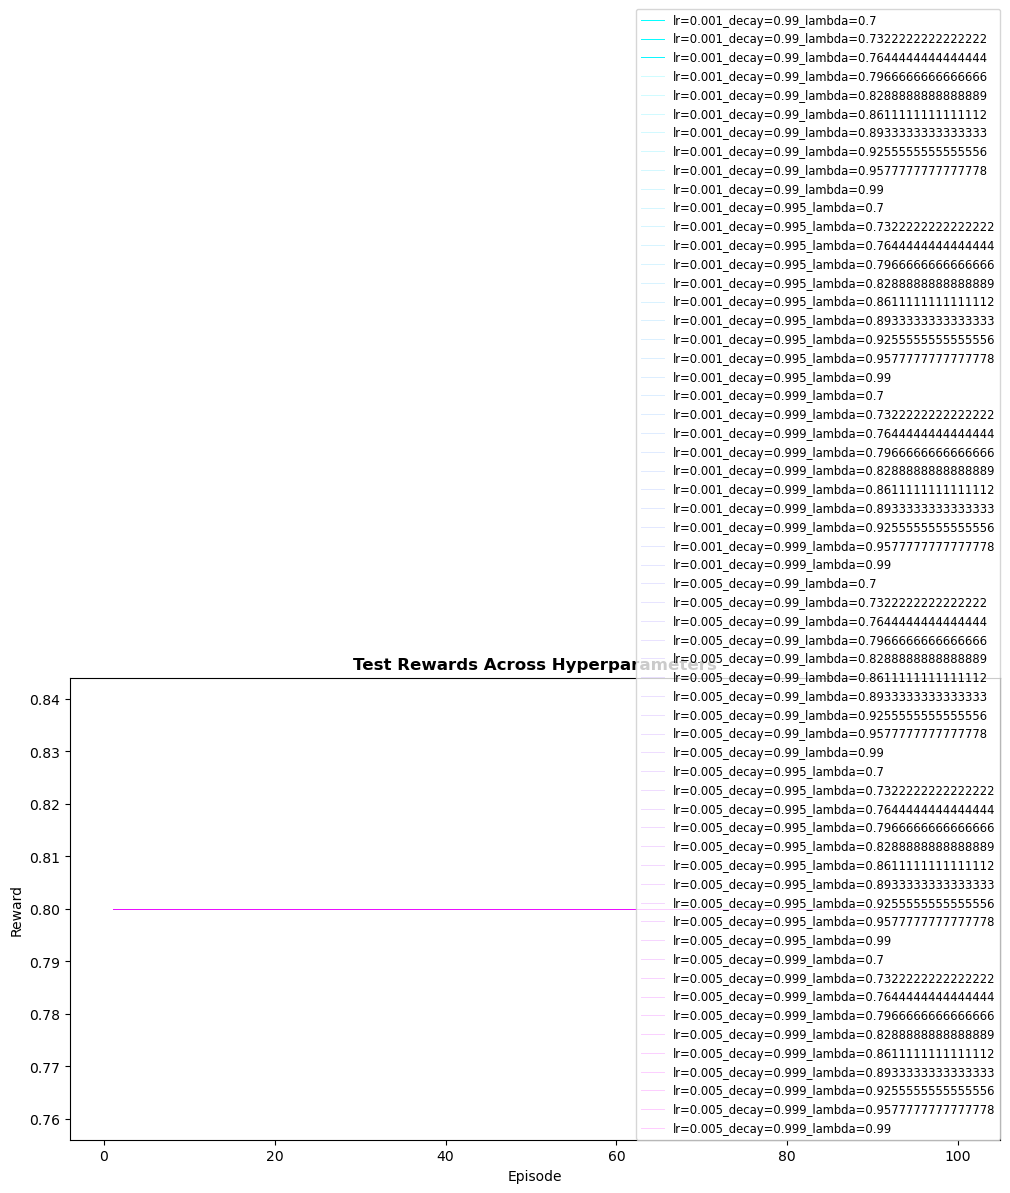

In [ ]:

# Function to plot the reward data with the cividis colormap and adjusted opacity
def plot_rewards_with_opacity(rewards_dict, title, xlabel, ylabel, img_name):
    # Calculate the mean reward for each hyperparameter combination
    mean_rewards = {key: np.mean(rewards) for key, rewards in rewards_dict.items()}
    
    # Identify the top 3 hyperparameter combinations based on mean reward
    top3_keys = sorted(mean_rewards, key=mean_rewards.get, reverse=True)[:3]
    
    # Create subplots
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Get the number of hyperparameter combinations
    num_combinations = len(rewards_dict)
    
    # Create a colormap instance
    cmap = cm.get_cmap("cool", num_combinations)
    
    # Loop through each hyperparameter combination and plot with a color from the colormap
    for idx, (key, rewards) in enumerate(rewards_dict.items()):
        color = cmap(idx)  # Get the color for this hyperparameter combination
        # Adjust opacity for non-top3 combinations
        alpha = 1.0 if key in top3_keys else 0.2
        ax.plot(range(1, len(rewards) + 1), rewards, label=key, color=color, alpha=alpha,linewidth=0.7)
    
    # Set title with bold font
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Place the legend in the bottom-right corner, remove title, and make it smaller
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0), borderaxespad=0., fancybox=True, fontsize='small', markerscale=0.5)
    fig.savefig(f'img/{img_name}.png',dpi=600) 
    plt.tight_layout()  # Ensures the legend does not get clipped
    plt.show()

# Plot for exp_res (training rewards)
# plot_rewards_with_opacity(exp_res, "Training Rewards Across Hyperparameters", "Episode", "Reward","TR_rewards.png")

# Plot for test_res (test rewards)
plot_rewards_with_opacity(test_res, "Test Rewards Across Hyperparameters", "Episode", "Reward","Ts_rewards.png")


In [10]:
env.observation_space

Box(0.0, 1.0, (180,), float64)

In [ ]:
def env_customization(update_step=0):
    """Override the step method dynamically based on update_option."""
    # Save the original step method
    original_step = FlappyBirdEnv.step

    def custom_step(self, action):
        """Custom step method to modify the reward for staying alive."""
        if update_step == 0:
            # Use the original step method
            return original_step(self, action)
        if update_step ==1:
            # Custom step logic (update_option != 0)
            terminal = False
            reward = None

            self._sound_cache = None
            if action == self.Actions.FLAP:
                if self._player_y > -2 * self.PLAYER_HEIGHT:
                    self._player_vel_y = self.PLAYER_FLAP_ACC
                    self._player_flapped = True
                    self._sound_cache = "wing"

            # Check for score
            player_mid_pos = self._player_x + self.PLAYER_WIDTH / 2
            for pipe in self._upper_pipes:
                pipe_mid_pos = pipe["x"] + self.PIPE_WIDTH / 2
                if pipe_mid_pos <= player_mid_pos < pipe_mid_pos + 4:
                    self._score += 1
                    reward = 1  # reward for passed pipe
                    self._sound_cache = "point"

            # Player movement and rotation
            if self._player_rot > -90:
                self._player_rot -= self.PLAYER_VEL_ROT
            if self._player_vel_y < self.PLAYER_MAX_VEL_Y and not self._player_flapped:
                self._player_vel_y += self.PLAYER_ACC_Y
            if self._player_flapped:
                self._player_flapped = False
                self._player_rot = 45
            self._player_y += min(
                self._player_vel_y, self._ground["y"] - self._player_y - self.PLAYER_HEIGHT
            )

            # Move pipes
            for up_pipe, low_pipe in zip(self._upper_pipes, self._lower_pipes):
                up_pipe["x"] += self.PIPE_VEL_X
                low_pipe["x"] += self.PIPE_VEL_X
                if up_pipe["x"] < -self.PIPE_WIDTH:
                    new_up_pipe, new_low_pipe = self._get_random_pipe()
                    up_pipe.update(new_up_pipe)
                    low_pipe.update(new_low_pipe)

            if self.render_mode == "human":
                self.render()

            obs, reward_private_zone = self._get_observation()
            if reward is None:
                if reward_private_zone is not None:
                    reward = reward_private_zone
                else:
                    reward = 0.1  # Change reward for staying alive

            # Agent touches the top of the screen
            if self._player_y < 0 or self._player_y + self.PLAYER_HEIGHT > self._ground["y"]:
                reward = -1.0
                terminal = True

            # Check for crash
            if self._check_crash():
                self._sound_cache = "hit"
                reward = -1  # reward for dying
                terminal = True
                self._player_vel_y = 0

            info = {"score": self._score}

            return (
                obs,
                reward,
                terminal,
                (self._score_limit is not None) and (self._score >= self._score_limit),
                info,
            )

        # Override the step method in FlappyBirdEnv
        FlappyBirdEnv.step = custom_step